Based on an invesigation of this twitter thread: https://twitter.com/daweonline/status/1367487367901310980

In [1]:
import scanpy as sc
import umap
from openTSNE import TSNE
from scipy import sparse
import numpy as np
from matplotlib import pyplot as plt

from itertools import product

# pbmc3k_processed

Note that this dataset has a scaled matrix in `.X`.

In [2]:
pbmc = sc.datasets.pbmc3k_processed()

## Making embeddings

In [5]:
RANDOM_STATE = 42
tsne_keys = []

for metric, knn_method in product(["euclidean", "cosine"], ["annoy", "pynndescent"]):
    key = f"tsne_{metric}_{knn_method}"
    tsne_keys.append(key)
    pbmc.obsm[key] = np.asarray(
        TSNE(
            n_jobs=-1,
            metric=metric,
            negative_gradient_method="bh",
            neighbors=knn_method,
            random_state=RANDOM_STATE,
        ).fit(pbmc.X)
    )

/usr/local/lib/python3.8/site-packages/openTSNE/nearest_neighbors.py:335: UserWarning: `pynndescent` has recently changed which distance metrics are supported, and `openTSNE.nearest_neighbors` has not been updated. Please notify the developers of this change.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/openTSNE/nearest_neighbors.py:335: UserWarning: `pynndescent` has recently changed which distance metrics are supported, and `openTSNE.nearest_neighbors` has not been updated. Please notify the developers of this change.
  warnings.warn(


In [6]:
umap_keys = []

for metric in ["euclidean", "cosine"]:
    key = f"umap_{metric}"
    pbmc.obsm[key] = umap.UMAP(
        n_jobs=-1,
        metric=metric,
    ).fit_transform(pbmc.X)
    umap_keys.append(key)

## Plots

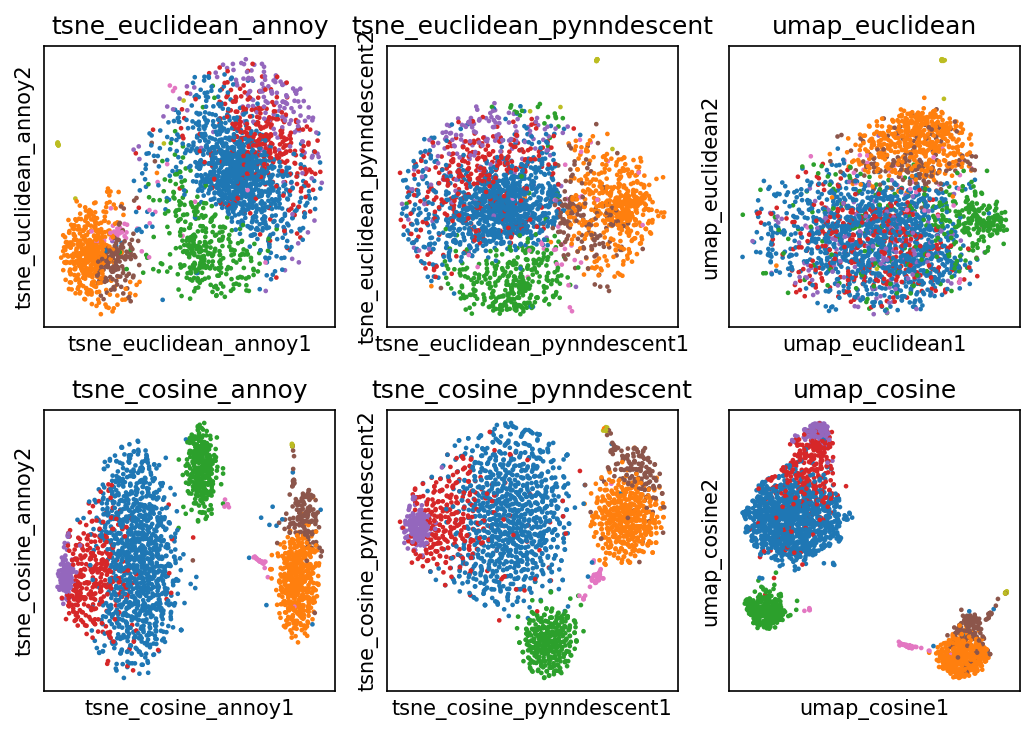

In [7]:
with plt.rc_context({"figure.dpi": 150, "figure.figsize": (7, 5)}):
    fig, axs = plt.subplots(ncols=3, nrows=2)
    for key, ax in zip(tsne_keys, axs[:, :2].flat):
        sc.pl.embedding(
            pbmc,
            basis=key,
            size=20,
            color="louvain",
            ax=ax,
            show=False,
            legend_loc=None,
            title=key,
        )
    for key, ax in zip(umap_keys, axs[:, 2].flat):
        sc.pl.embedding(
            pbmc,
            basis=key,
            size=20,
            color="louvain",
            ax=ax,
            show=False,
            legend_loc=None,
            title=key,
        )
    plt.tight_layout()

# Looking at a bigger dataset

Takes a while to process.

In [8]:
adata = sc.datasets.ebi_expression_atlas("E-HCAD-10", filter_boring=True)

  0%|          | 0.00/14.9M [00:00<?, ?B/s]

0.00B [00:00, ?B/s]

... storing 'Sample Characteristic[organism]' as categorical
... storing 'Sample Characteristic Ontology Term[organism]' as categorical
... storing 'Sample Characteristic[individual]' as categorical
... storing 'Sample Characteristic[sex]' as categorical
... storing 'Sample Characteristic Ontology Term[sex]' as categorical
... storing 'Sample Characteristic[gestational age]' as categorical
... storing 'Sample Characteristic[developmental stage]' as categorical
... storing 'Sample Characteristic Ontology Term[developmental stage]' as categorical
... storing 'Sample Characteristic[organism part]' as categorical
... storing 'Sample Characteristic Ontology Term[organism part]' as categorical
... storing 'Sample Characteristic[immunophenotype]' as categorical
... storing 'Sample Characteristic[disease]' as categorical
... storing 'Sample Characteristic Ontology Term[disease]' as categorical
... storing 'Sample Characteristic[organism status]' as categorical
... storing 'Sample Characteristi

## Preprocessing

In [9]:
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_genes(adata, min_counts=1)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.highly_variable_genes(adata)

/usr/local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [10]:
sc.pp.highly_variable_genes(adata)

## Making embeddings

In [11]:
X_hvg = adata.X[:, adata.var["highly_variable"]]
X_hvg_scaled = sc.pp.scale(X_hvg)

In [12]:
keys = []

for metric in ["euclidean", "cosine"]:
    key = f"umap_{metric}"
    adata.obsm[key] = umap.UMAP(
        n_jobs=-1,
        metric=metric,
    ).fit_transform(X_hvg)
    print(key)
    keys.append(key)

for metric in ["euclidean", "cosine"]:
    key = f"umap_{metric}_scaled"
    adata.obsm[key] = umap.UMAP(
        n_jobs=-1,
        metric=metric,
    ).fit_transform(X_hvg_scaled)
    print(key)
    keys.append(key)

umap_euclidean
umap_cosine
umap_euclidean_scaled
umap_cosine_scaled


## Plots

umap_euclidean


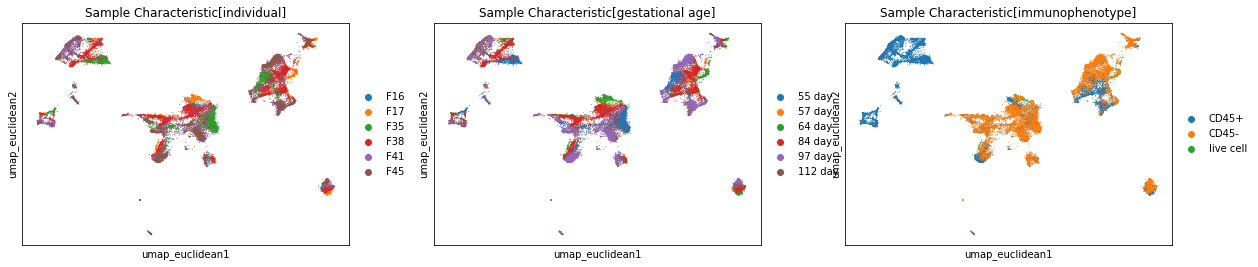

umap_cosine


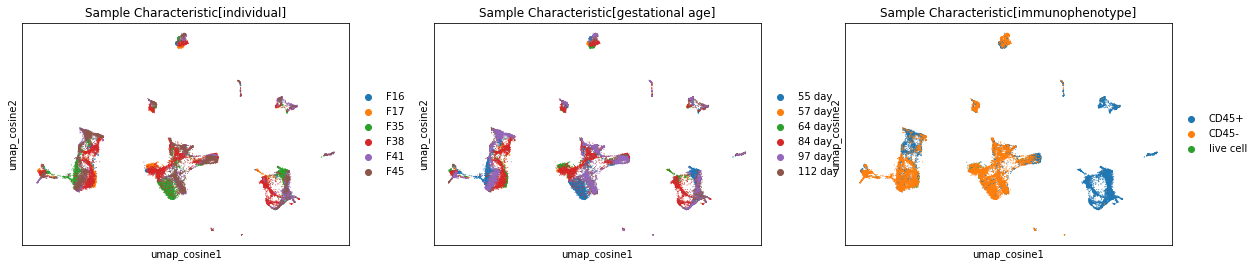

umap_euclidean_scaled


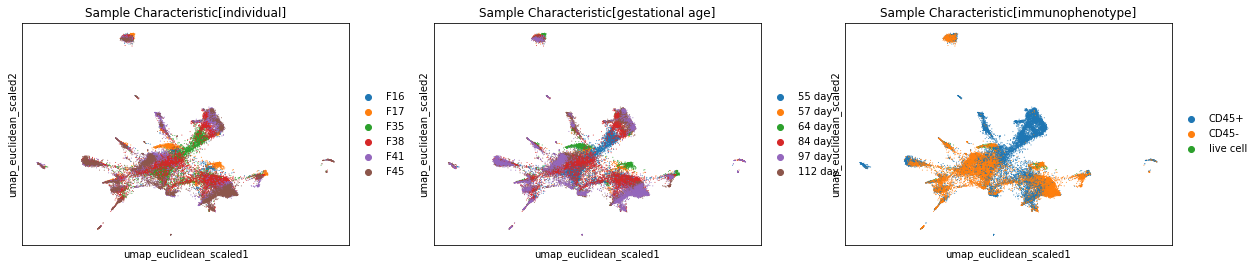

umap_cosine_scaled


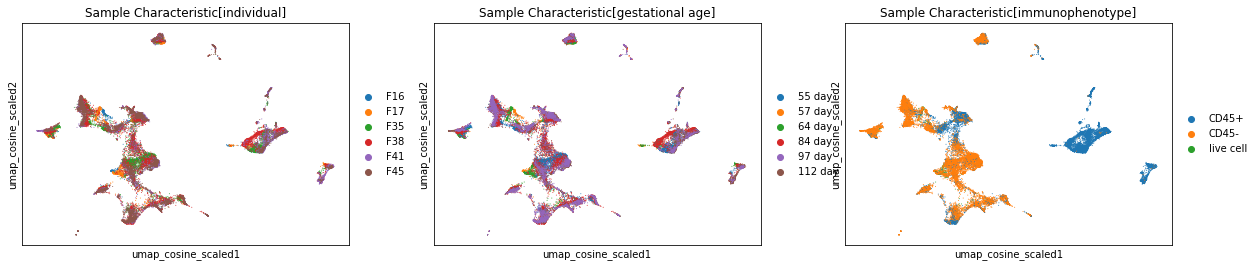

In [13]:
cols = [
    "Sample Characteristic[individual]",
    "Sample Characteristic[gestational age]",
    "Sample Characteristic[immunophenotype]",
]

for key in keys:
    print(key)
    sc.pl.embedding(adata, key, color=cols)

I think it's very fair to say there is less structure in the `umap_euclidean_scaled` plots than any of the others.

# scvelo dentate gyrus

## Preprocessing

In [14]:
dgs = sc.read(
    "./data/DentateGyrus/10X43_1.h5ad",
    backup_url="https://github.com/theislab/scvelo_notebooks/raw/master/data/DentateGyrus/10X43_1.h5ad"
)
dgs

AnnData object with n_obs × n_vars = 2930 × 13913
    obs: 'clusters', 'age(days)', 'clusters_enlarged'
    uns: 'clusters_colors'
    obsm: 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [15]:
dgs.layers["counts"] = dgs.X.copy()
sc.pp.normalize_total(dgs)
sc.pp.log1p(dgs)

## Reference plot

In [16]:
sc.pp.pca(dgs)
sc.pp.neighbors(dgs)
sc.tl.umap(dgs)

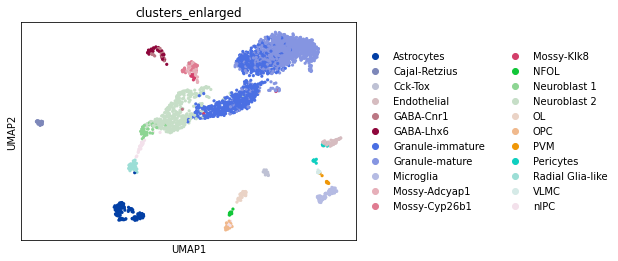

In [17]:
sc.pl.umap(dgs, color="clusters_enlarged")

In [18]:
sc.pp.highly_variable_genes(dgs) # Since dense scaled matrix would be huge otherwise

In [19]:
dgs

AnnData object with n_obs × n_vars = 2930 × 13913
    obs: 'clusters', 'age(days)', 'clusters_enlarged'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'log1p', 'pca', 'neighbors', 'umap', 'clusters_enlarged_colors', 'hvg'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts'
    obsp: 'distances', 'connectivities'

## Making embeddings

In [20]:
X_hvg = dgs.X[:, dgs.var["highly_variable"]]
X_hvg_scaled = sc.pp.scale(X_hvg)

In [21]:
reps = {
    "X_hvg_scaled": X_hvg_scaled,
    "X_hvg": X_hvg,
#     "X": dgs.X
}

keys = []

metrics = ["euclidean", "cosine"]

for rep, metric in product(reps, metrics):
    rep_X = reps[rep]
    key = f"umap_{metric}_{rep}"
    dgs.obsm[key] = umap.UMAP(
        n_jobs=-1,
        metric=metric,
    ).fit_transform(rep_X)
    keys.append(key)

# Plots

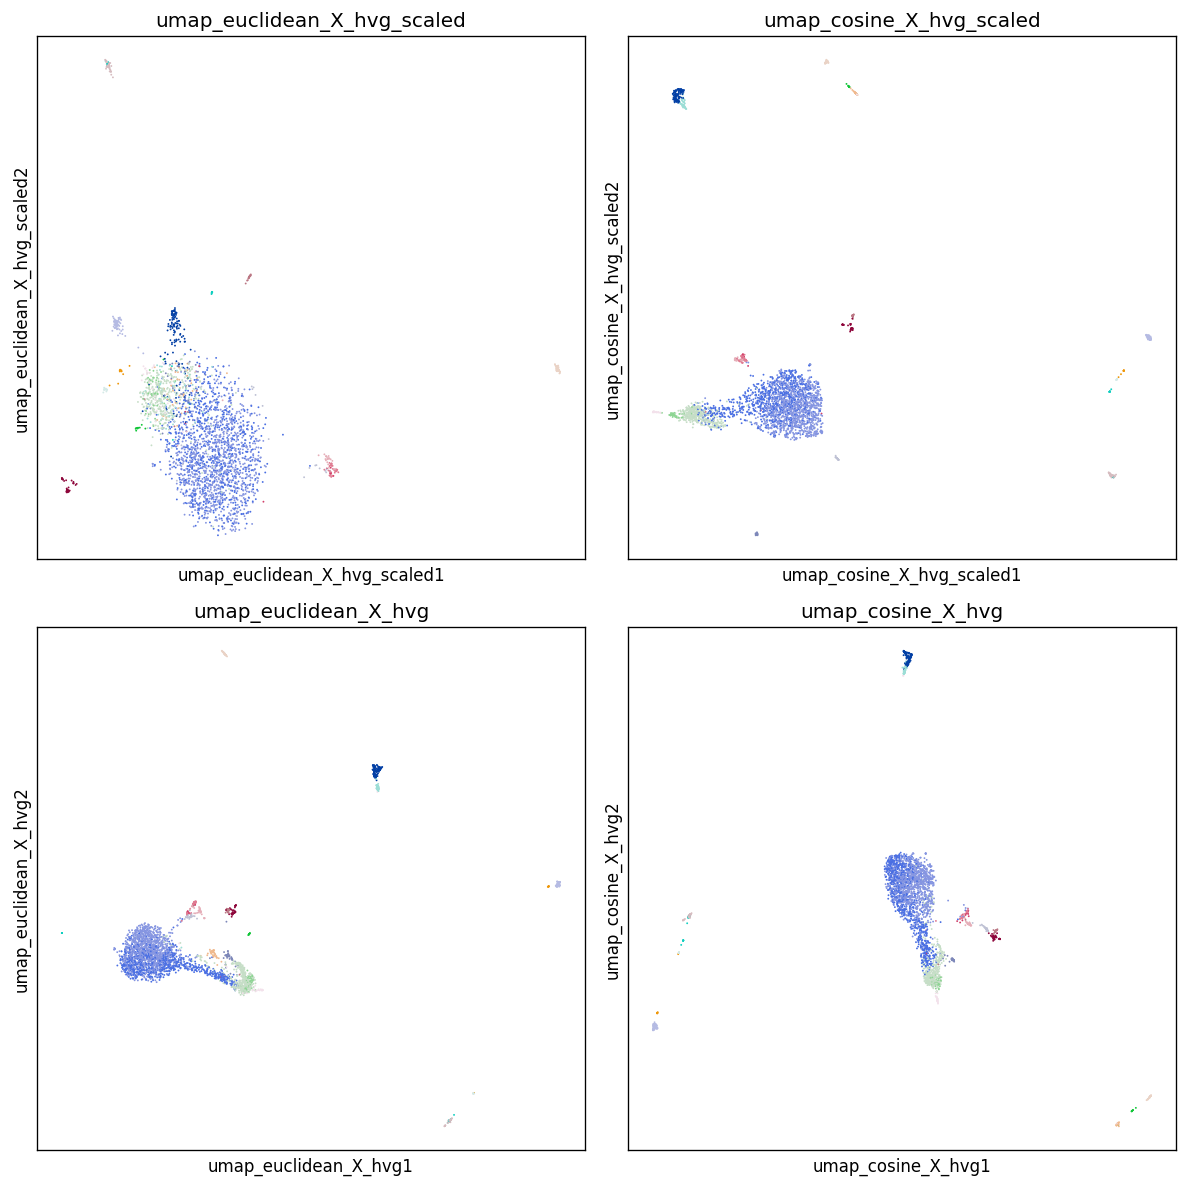

In [23]:
with plt.rc_context({"figure.figsize": (10, 10), "figure.dpi": 120}):
    fig, axs = plt.subplots(nrows=len(metrics), ncols=len(reps))
    for (rep, metric), ax in zip(product(reps, metrics), axs.flat):
        key = f"umap_{metric}_{rep}"
        sc.pl.embedding(dgs, key, color="clusters_enlarged", size=5, legend_loc=None, ax=ax, show=False, title=key)
    plt.tight_layout()

Top row is scaled, bottom row is unscaled. I think it's harder to tell what's happening here since there is so much empty space, but I think we can say there's less separation for some groups in with the embedding based on euclidean scaled data. For example the chain of `PVM`, `Microglia`, and `VLMC` are much closer to the large cluster.